In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
transition_probs = pd.read_csv('transition_probs.csv')

## Build transition matrix

In [4]:
tr_pr = transition_probs.pivot_table(
    index='score_diff_state', 
    columns='next_score_diff_state', 
    values='prob',
    fill_value=0 # replace missing transitions with 0 probability
)

## Plot Heatmap

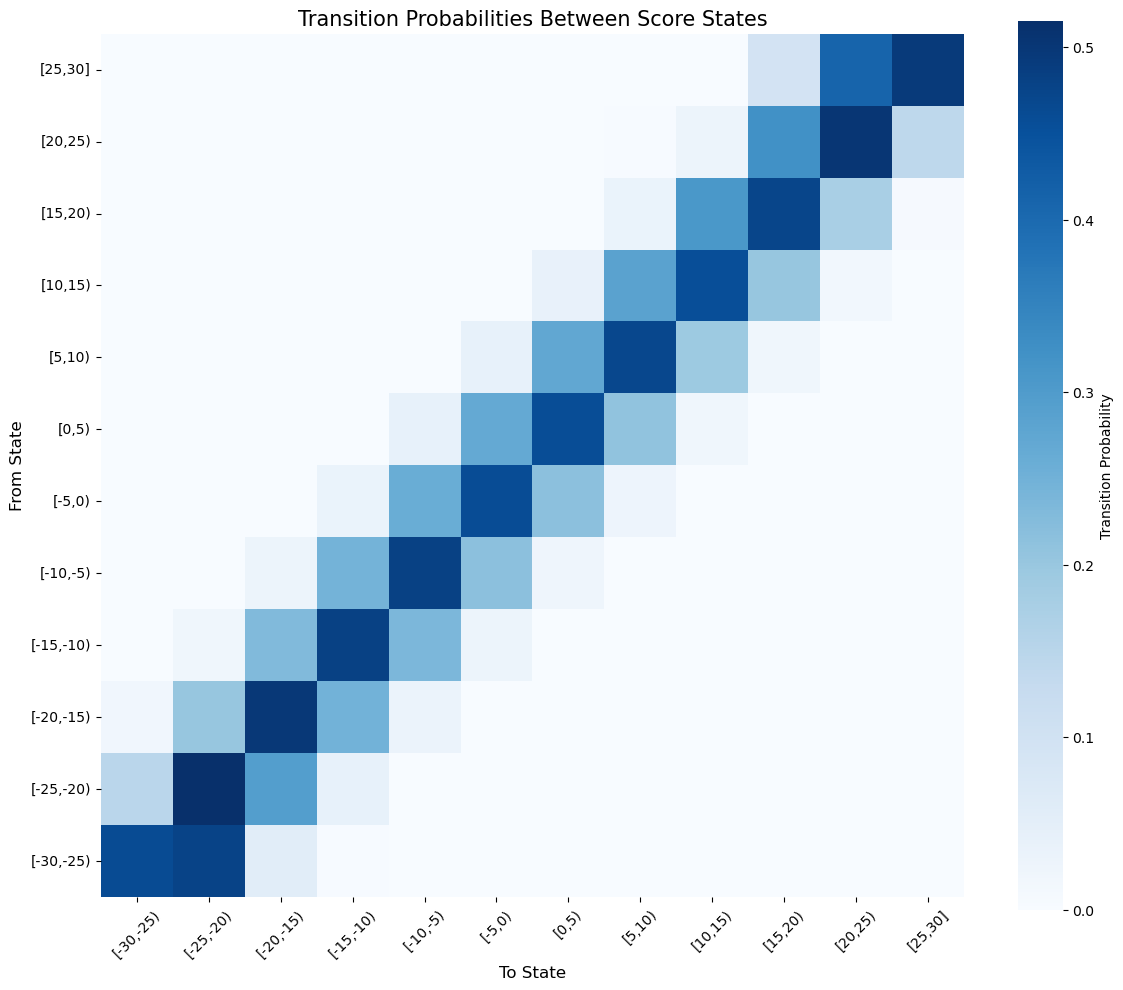

In [5]:
# reorder states
def extract_lower_bound(label):
    return float(label.strip('[]()').split(',')[0])

sorted_states = sorted(tr_pr.index, key=extract_lower_bound)

tr_pr_sorted = tr_pr.loc[sorted_states, sorted_states[::-1]]

plt.figure(figsize=(12, 10))
sns.heatmap(
    tr_pr_sorted, 
    cmap='Blues',
    square=True,
    xticklabels=sorted_states,
    yticklabels=sorted_states[::-1], # deficit (bottom) -> lead (top)
    cbar_kws={'label': 'Transition Probability'}
)

plt.title('Transition Probabilities Between Score States', fontsize=15)
plt.xlabel('To State', fontsize=12)
plt.ylabel('From State', fontsize=12)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

## Simulate 2nd half of UVA vs. NC Central (+17 initial score state)

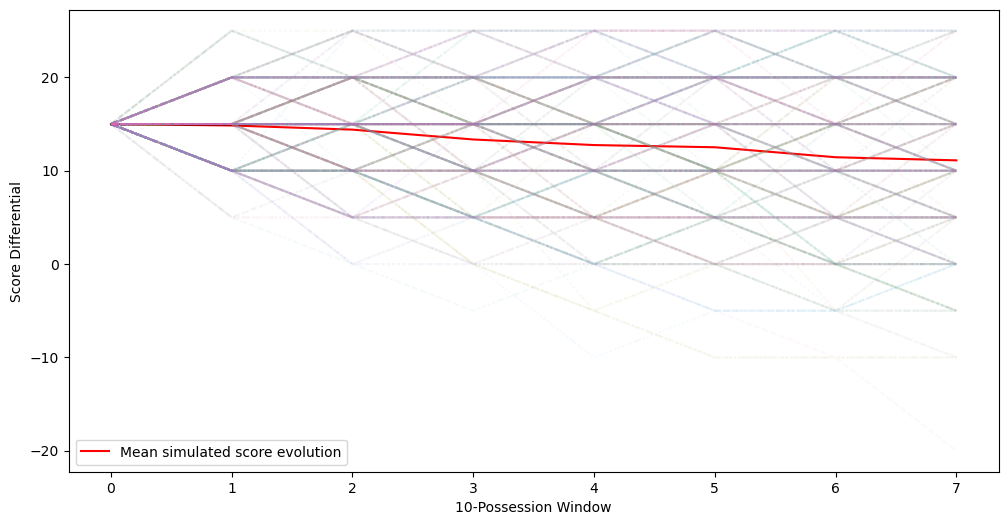

In [12]:
states = tr_pr.index.tolist()
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

# Convert transition matrix to np array
P = tr_pr.values  # rows sum to 1

# Set initial state (+17)
init_state = '[15,20)'
init_idx = state_to_idx[init_state]

T = 7 # time steps
n_sim = 360 # simulations

rng = np.random.default_rng(seed=42)

# Simulate paths
paths = np.zeros((T + 1, n_sim), dtype=int)
paths[0, :] = init_idx

for t in range(1, T + 1):
    for sim in range(n_sim):
        current_idx = paths[t - 1, sim]
        paths[t, sim] = rng.choice(
            len(states), 
            p=P[current_idx]
        )

# Map categorical states to numeric score differentials
score_values = np.array([extract_lower_bound(s) for s in states])
scores = score_values[paths]

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(T + 1), y=scores.mean(axis=1), color='red', label='Mean simulated score evolution')
sns.lineplot(data=scores, alpha=0.05, legend=False)
plt.xlabel('10-Possession Window')
plt.ylabel('Score Differential')
plt.legend()
plt.show()


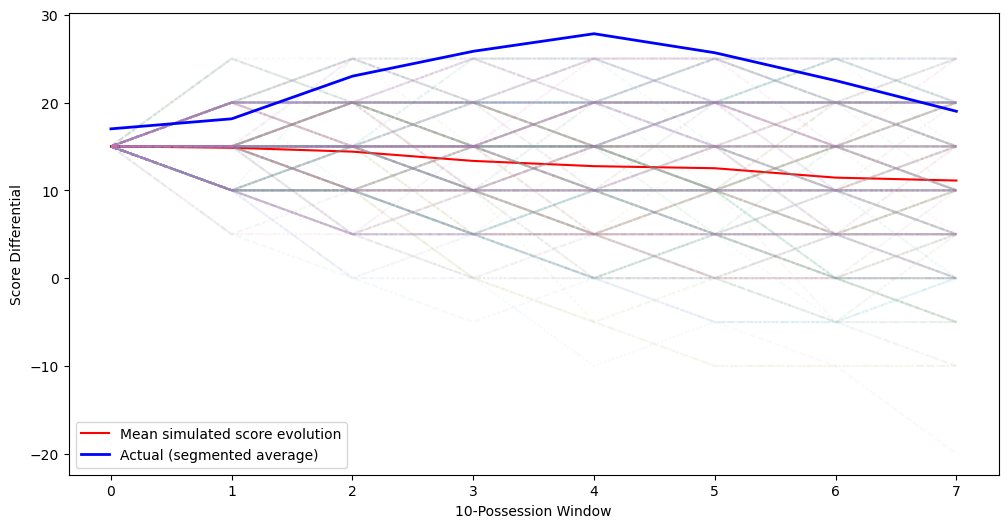

In [13]:
actual_score_differentials = [17, 15, 17, 18, 19, 21, 20, 19, 21, 23, 26, 25, 24, 21, 24, 25, 26, 28, 31, 28, 26, 28, 27, 30, 28, 27, 25, 28, 27, 25, 22, 25, 24, 23, 21, 20, 22, 20, 18, 20, 19, 18, 19]
states = tr_pr.index.tolist()
state_to_idx = {s: i for i, s in enumerate(states)}
idx_to_state = {i: s for i, s in enumerate(states)}

# Convert transition matrix to np array
P = tr_pr.values  # rows sum to 1

# Set initial state (+17)
init_state = '[15,20)'
init_idx = state_to_idx[init_state]

T = 7 # time steps
n_sim = 360 # simulations

rng = np.random.default_rng(seed=42)

# Simulate paths
paths = np.zeros((T + 1, n_sim), dtype=int)
paths[0, :] = init_idx

for t in range(1, T + 1):
    for sim in range(n_sim):
        current_idx = paths[t - 1, sim]
        paths[t, sim] = rng.choice(
            len(states), 
            p=P[current_idx]
        )

# Map categorical states to numeric score differentials
score_values = np.array([extract_lower_bound(s) for s in states])
scores = score_values[paths]

plt.figure(figsize=(12, 6))
sns.lineplot(x=range(T + 1), y=scores.mean(axis=1), color='red', label='Mean simulated score evolution')
sns.lineplot(data=scores, alpha=0.05, legend=False)
# aggregate actual score differentials into T segments and produce T+1 points (keep start/end as actual)
arr = np.array(actual_score_differentials)
chunks = np.array_split(arr, T)
chunk_means = np.array([c.mean() for c in chunks])

reduced_actual = np.empty(T + 1)
reduced_actual[0] = arr[0]
reduced_actual[-1] = arr[-1]
if T > 1:
    reduced_actual[1:-1] = chunk_means[:-1]  # use the first T-1 chunk means for interior points

plt.plot(range(T + 1), reduced_actual, color='blue', linewidth=2, label='Actual (segmented average)')
plt.xlabel('10-Possession Window')
plt.ylabel('Score Differential')
plt.legend()
plt.show()
